In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [3]:
import cache_magic
import numpy as np
import scipy as sp
import pandas as pd
import plotly.express as ex
import plotly.graph_objects as go
import concurrent.futures
from copy import deepcopy
import qrandom as qr
import qrandom.numpy as qrnp

from tracking_v2.target import NearConstantVelocityTarget
from tracking_v2.kalman import LinearKalmanFilter
from tracking_v2.motion import ConstantVelocityModel
from tracking_v2.sensor import GeometricSensor
from tracking_v2.evaluation import FilterRunner, evaluate_runner, plot_nscore, plot_runs

from tracking_v2.util import to_df, display

%cache magic is now registered in ipython


In [4]:
display.as_png = True

# Summary

For Near-Constant velocity target and a matching motion model:

## NEES
 
NEES seems to be almost statistically consistent: NEES averaged over 100 independent runs is definitely consistent with the confidence interval.

However, for any individual run, NEES has the tendency to build up and fall, staying outside of the confidence interval (CI) for prolonged periods. Compared to NEES for `Q=1e-5` or `Q=1e-3` which do not show this behavior, it is clear that NEES for `Q=0` does not behave in a statistically-consistent manner.

Grok thinks that this is due to numerical errors in inverting a matrix which is essentially going down to zero, or some other numerical error.

## NIS

NIS includes the measurement error and is statistically consistent for all tested values of `Q`.

In [5]:
Q = 0
target = NearConstantVelocityTarget(noise_intensity=Q)
motion = ConstantVelocityModel(noise_intensity=Q)
kf = LinearKalmanFilter(motion, [[1, 0, 0, 0, 0, 0],
                                 [0, 1, 0, 0, 0, 0],
                                 [0, 0, 1, 0, 0, 0]])
sensor = GeometricSensor()

r = FilterRunner(target, sensor, kf)
r.run_many(100, 1000)

e_Q0 = evaluate_runner(r)

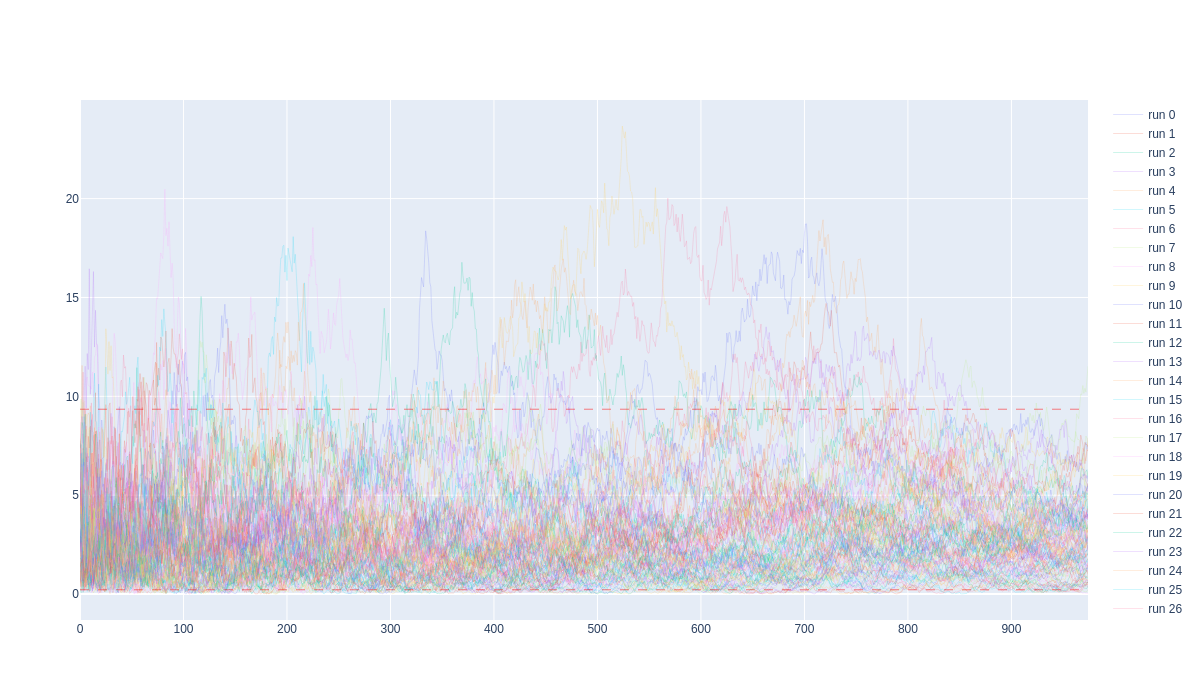

In [6]:
display(plot_runs(e_Q0.position_nees))

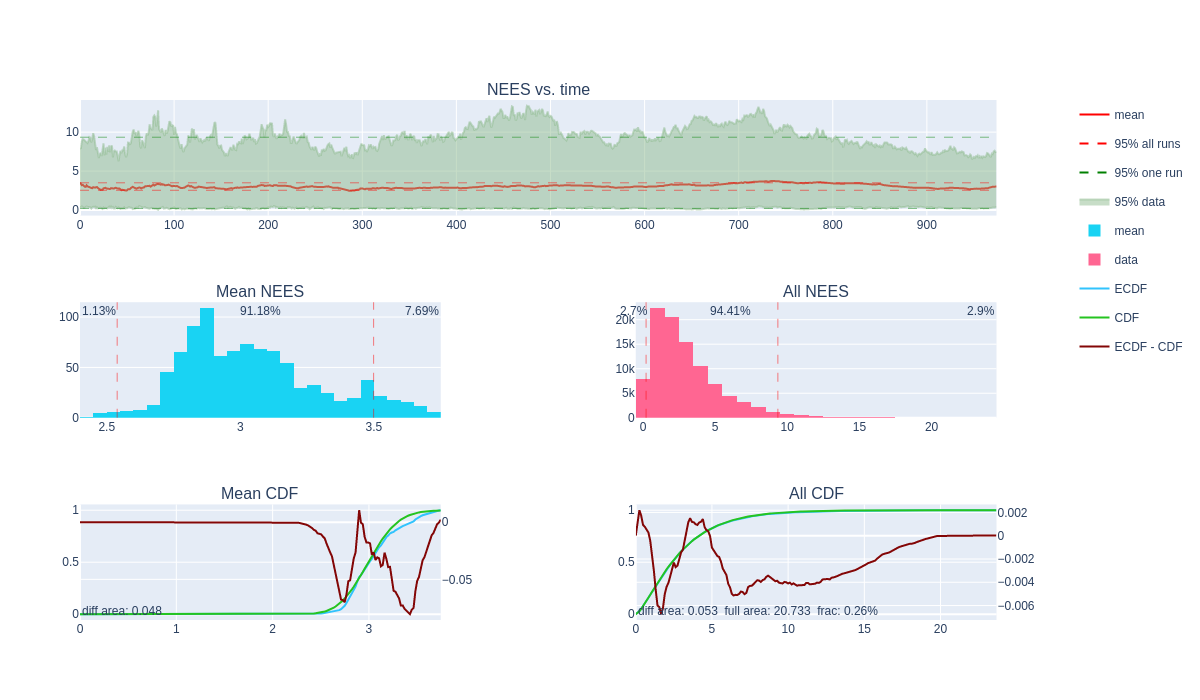

In [7]:
display(plot_nscore(e_Q0.position_nees))

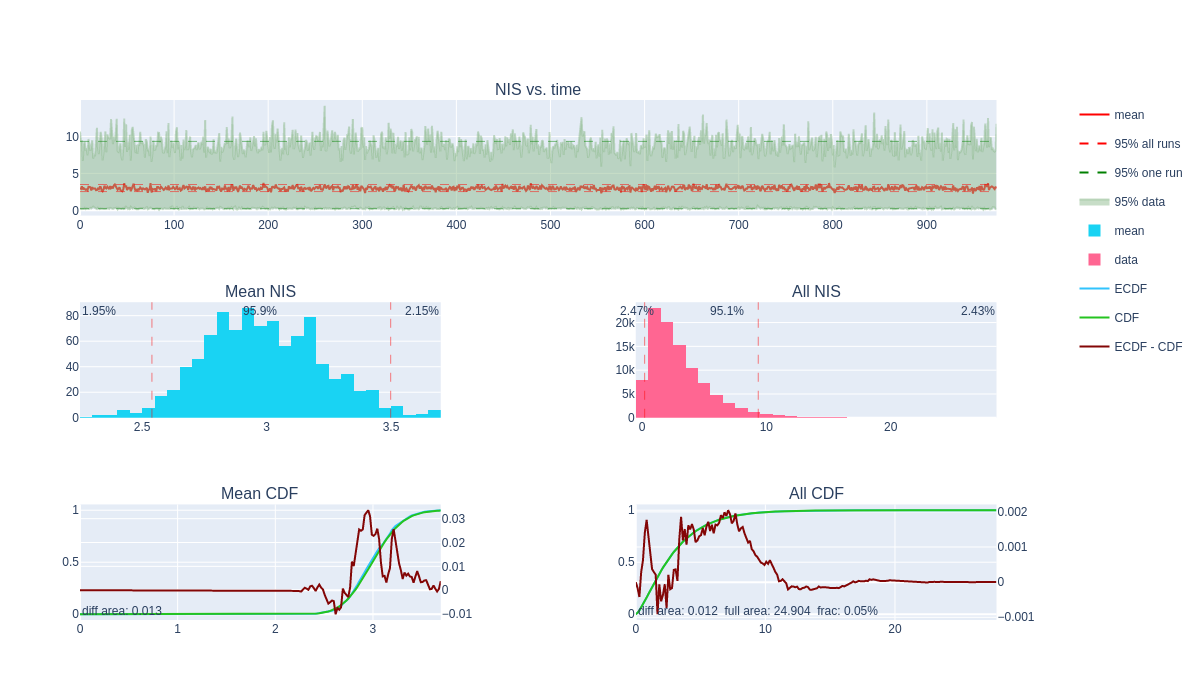

In [8]:
display(plot_nscore(e_Q0.position_nis))

In [9]:
Q = 0.00001
target = NearConstantVelocityTarget(noise_intensity=Q)
motion = ConstantVelocityModel(noise_intensity=Q)
kf = LinearKalmanFilter(motion, [[1, 0, 0, 0, 0, 0],
                                 [0, 1, 0, 0, 0, 0],
                                 [0, 0, 1, 0, 0, 0]])
sensor = GeometricSensor()

r = FilterRunner(target, sensor, kf)
r.run_many(100, 1000)

e_Q1e5 = evaluate_runner(r)

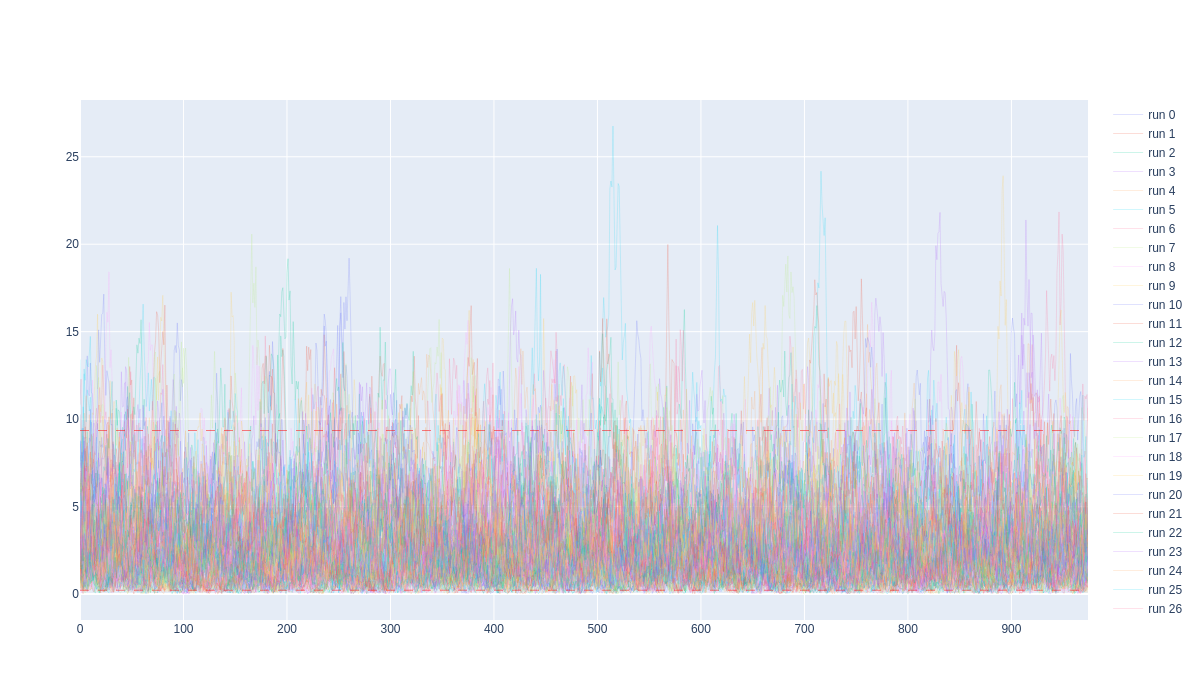

In [10]:
display(plot_runs(e_Q1e5.position_nees))

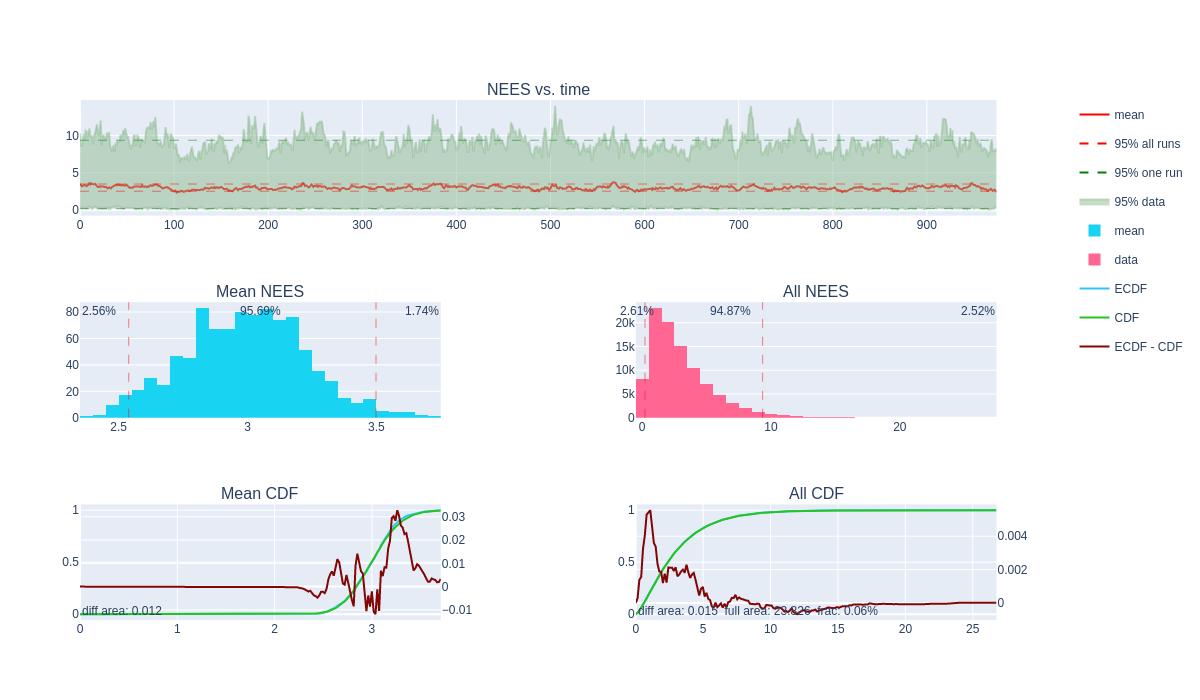

In [11]:
display(plot_nscore(e_Q1e5.position_nees))

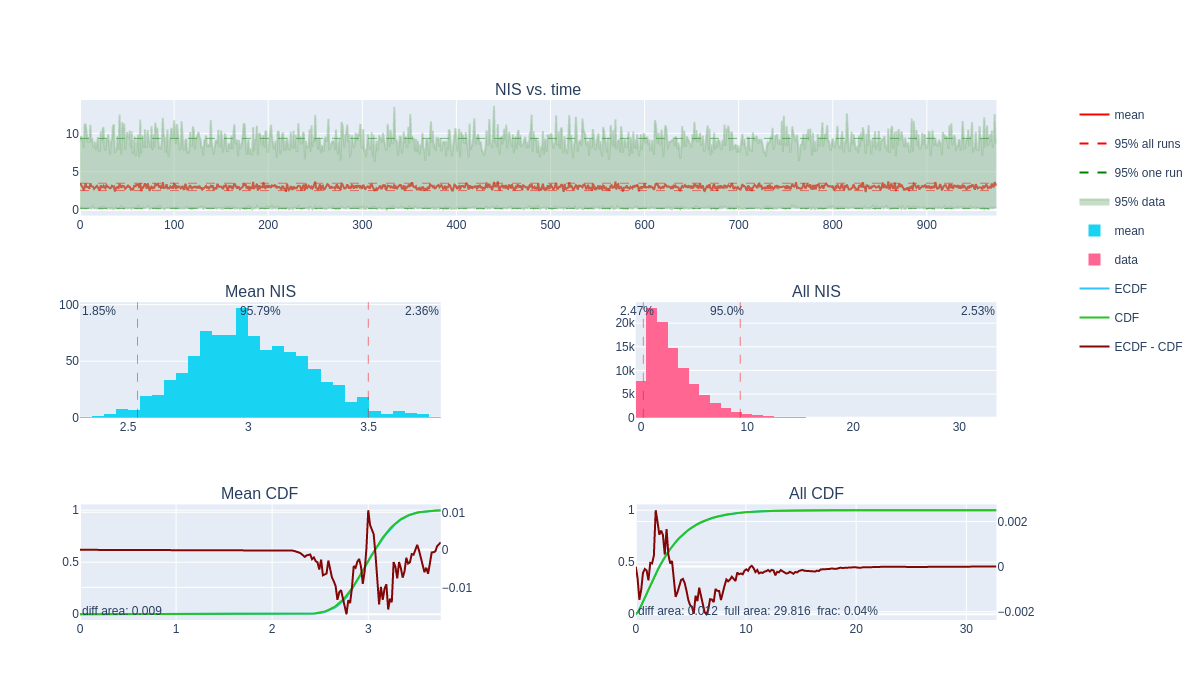

In [12]:
display(plot_nscore(e_Q1e5.position_nis))

In [13]:
Q = 0.001
target = NearConstantVelocityTarget(noise_intensity=Q)
motion = ConstantVelocityModel(noise_intensity=Q)
kf = LinearKalmanFilter(motion, [[1, 0, 0, 0, 0, 0],
                                 [0, 1, 0, 0, 0, 0],
                                 [0, 0, 1, 0, 0, 0]])
sensor = GeometricSensor()

r = FilterRunner(target, sensor, kf)
r.run_many(100, 1000)

e_Q1e3 = evaluate_runner(r)

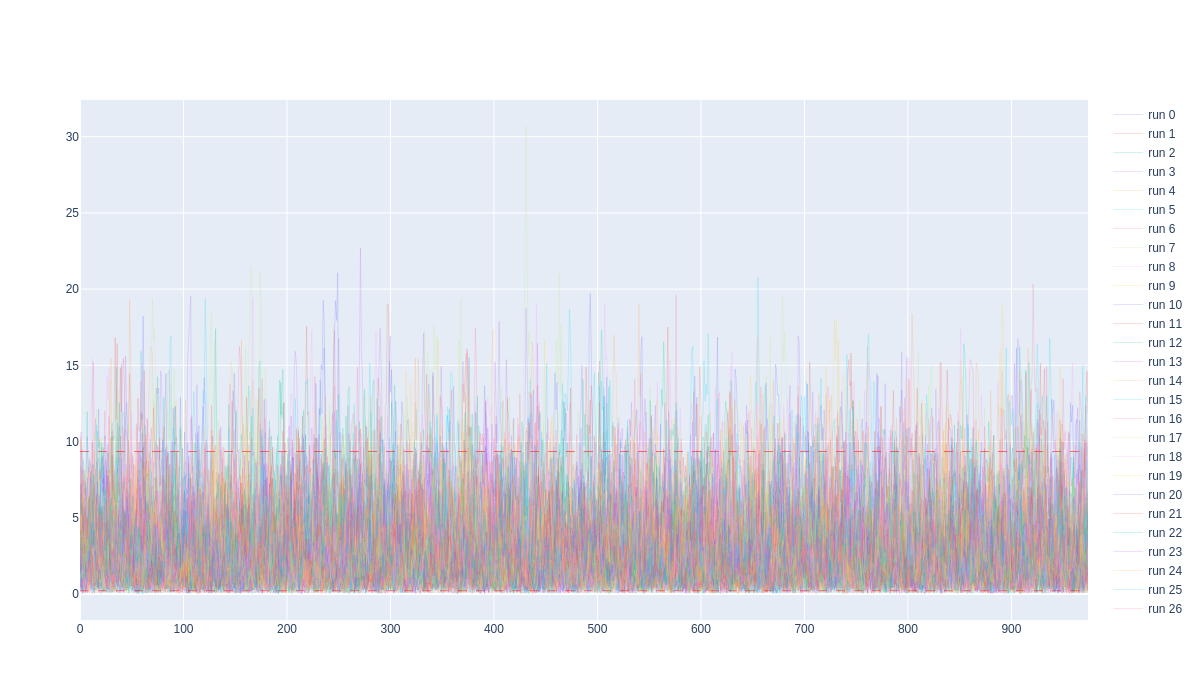

In [14]:
display(plot_runs(e_Q1e3.position_nees))

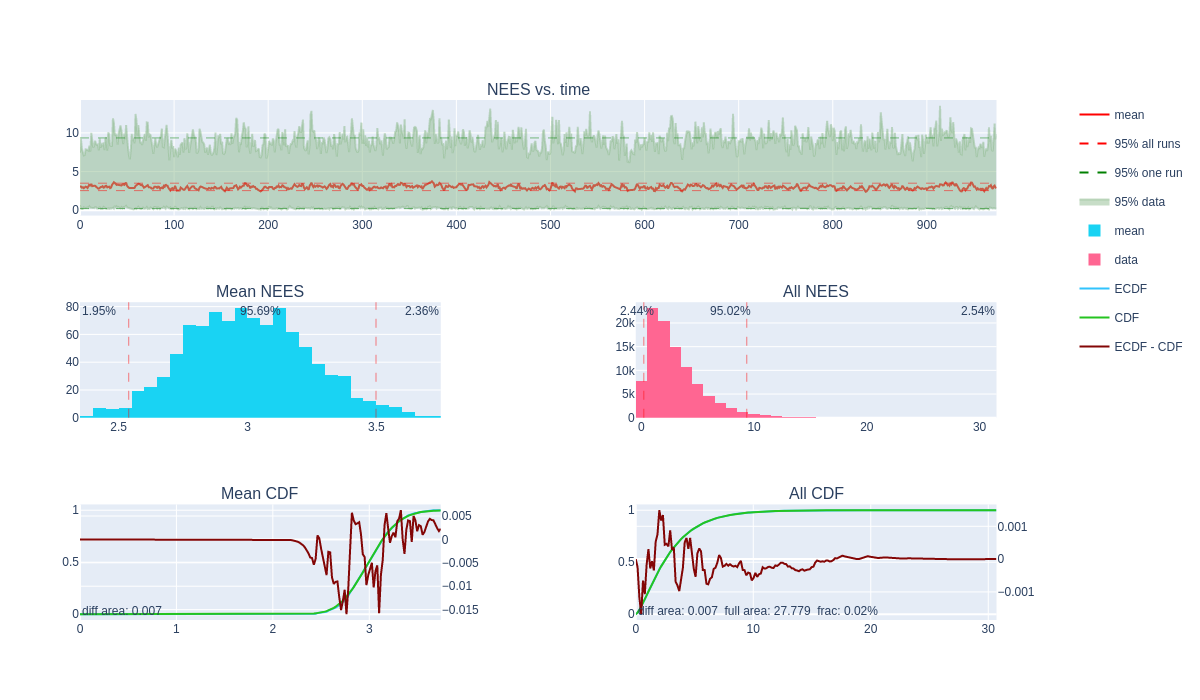

In [15]:
display(plot_nscore(e_Q1e3.position_nees))

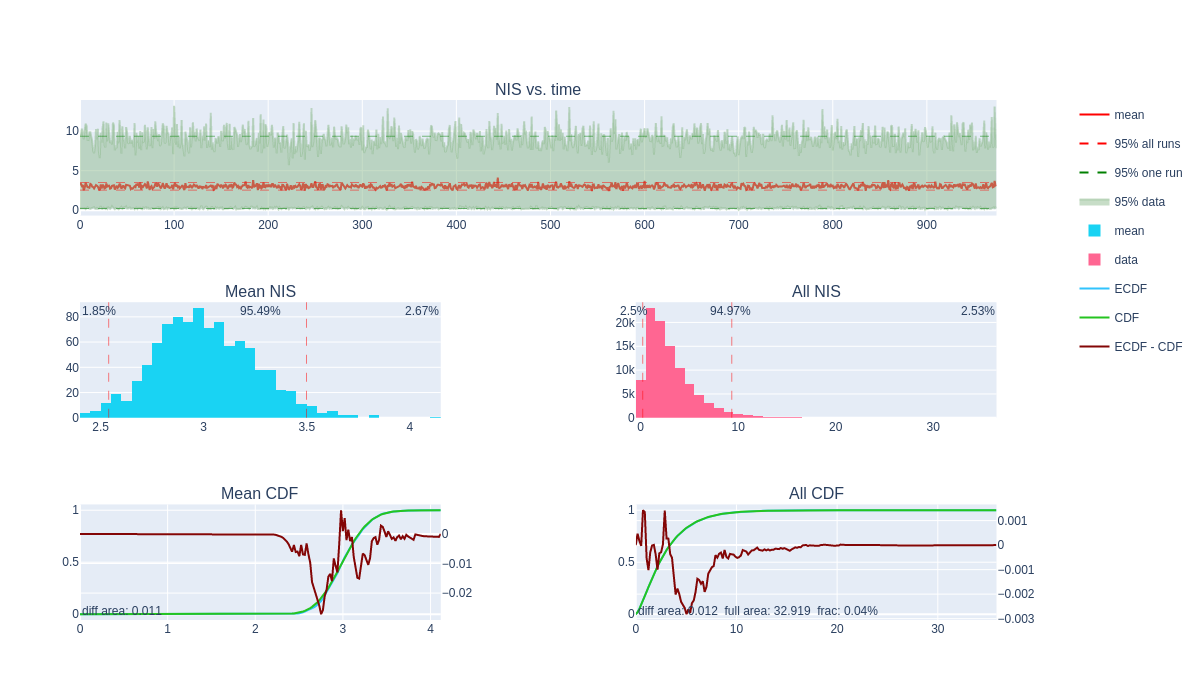

In [16]:
display(plot_nscore(e_Q1e3.position_nis))

In [17]:
Q = 1
target = NearConstantVelocityTarget(noise_intensity=Q)
motion = ConstantVelocityModel(noise_intensity=Q)
kf = LinearKalmanFilter(motion, [[1, 0, 0, 0, 0, 0],
                                 [0, 1, 0, 0, 0, 0],
                                 [0, 0, 1, 0, 0, 0]])
sensor = GeometricSensor()

r = FilterRunner(target, sensor, kf)
r.run_many(100, 400)

e_Q1 = evaluate_runner(r)

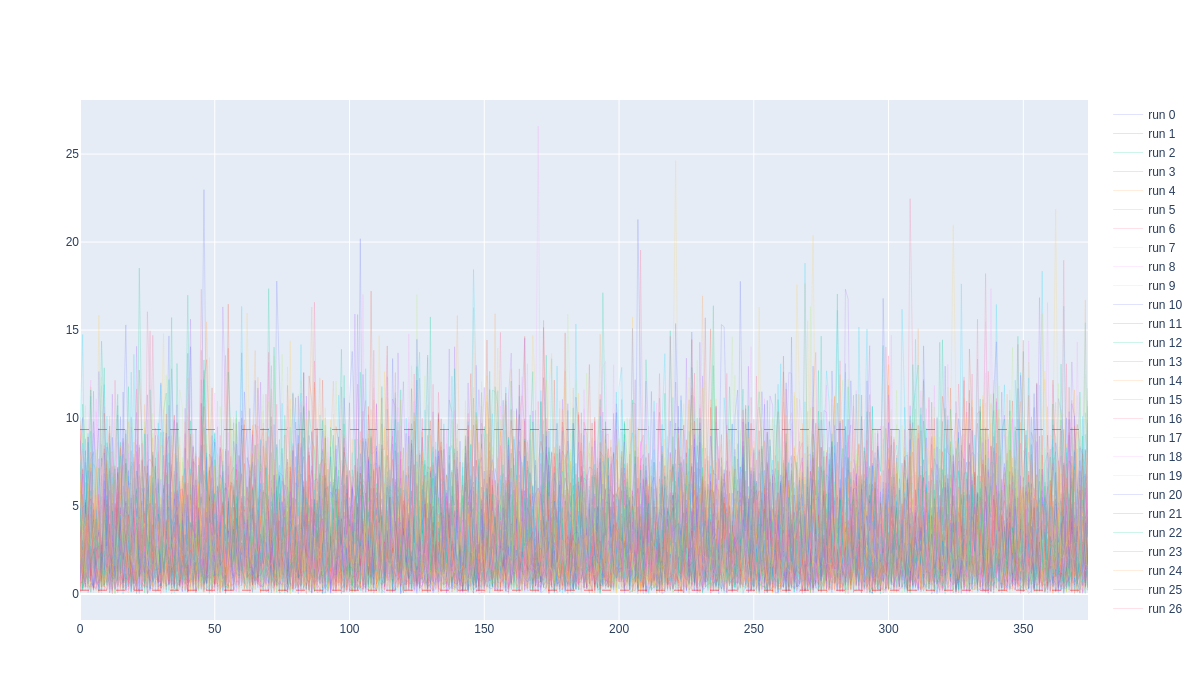

In [18]:
display(plot_runs(e_Q1.position_nees))

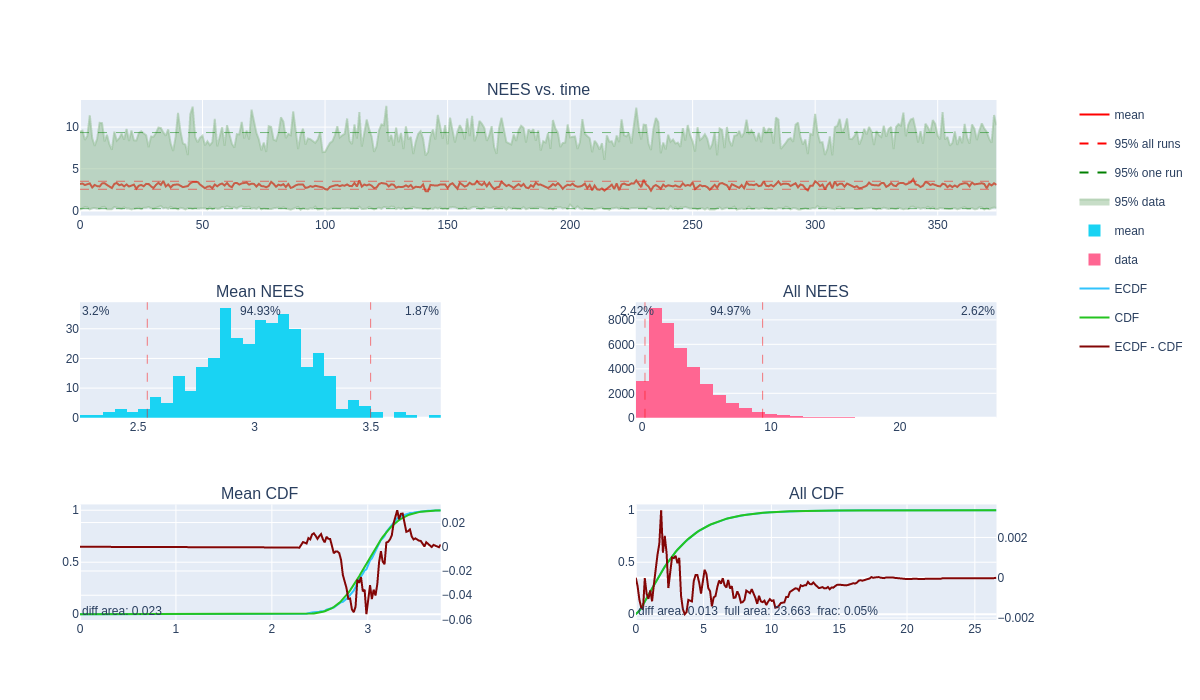

In [19]:
display(plot_nscore(e_Q1.position_nees))

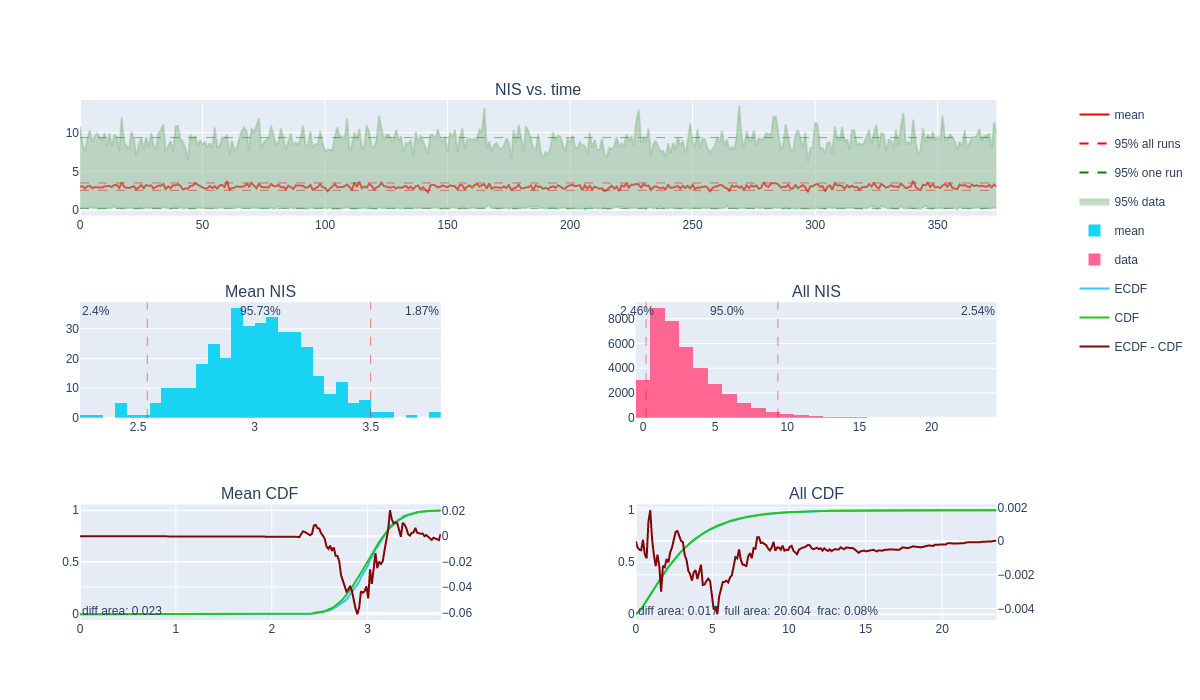

In [20]:
display(plot_nscore(e_Q1.position_nis))

# Number of consequitive NEES and NIS, outside of the 95% CI

In [21]:
def interval_lengths(scores):
    # confidence interval for an individual run
    conf_int = sp.stats.chi2.ppf([0.025, 0.975], 3)
    
    greater_than = (scores > conf_int[1]).astype(int)
    
    zeroes = np.full((scores.shape[0], 1), 0)
    greater_than_padded = np.hstack((zeroes, greater_than, zeroes))
    
    diffs = np.diff(greater_than_padded)
    
    starts = np.where(diffs.reshape(-1) == 1)[0]
    ends = np.where(diffs.reshape(-1) == -1)[0]
    
    return ends - starts

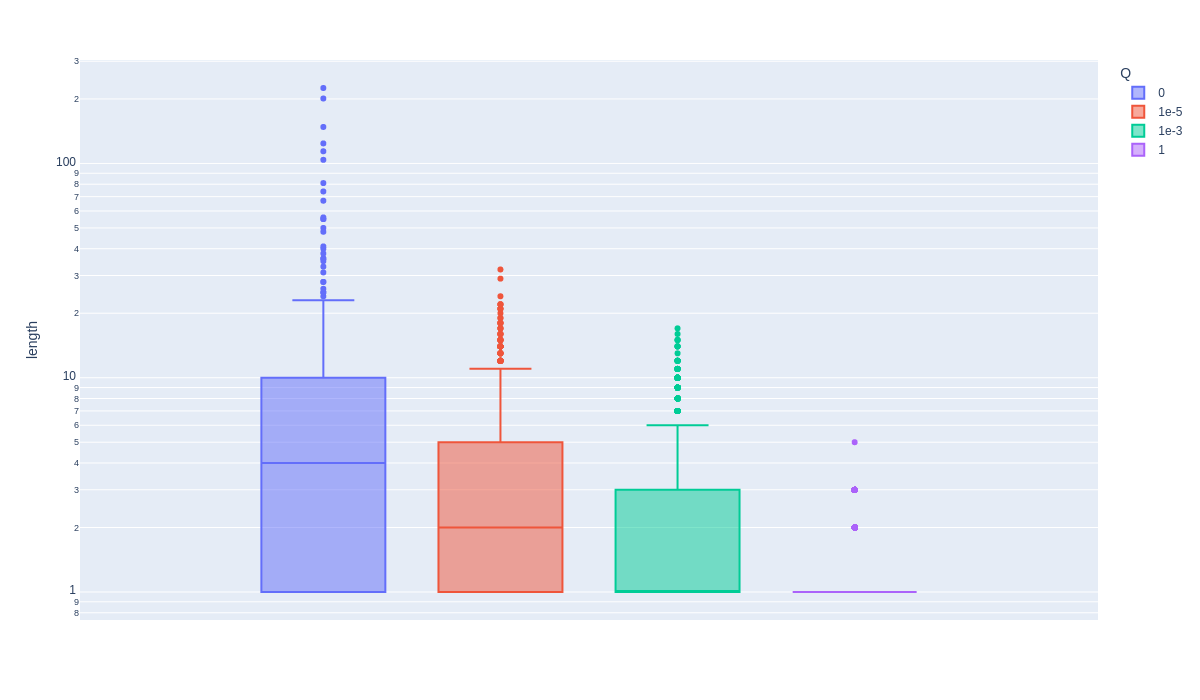

In [22]:
df = pd.concat([
    to_df(interval_lengths(e_Q0.position_nees.scores), columns=['length']).assign(Q='0'),
    to_df(interval_lengths(e_Q1e5.position_nees.scores), columns=['length']).assign(Q='1e-5'),
    to_df(interval_lengths(e_Q1e3.position_nees.scores), columns=['length']).assign(Q='1e-3'),
    to_df(interval_lengths(e_Q1.position_nees.scores), columns=['length']).assign(Q='1')
])

display(ex.box(df, y='length', color='Q', log_y=True))

# Real random numbers

It would be interesting to see whether using real random numbers (rather than pseudo-random numbers) changes any of the above, and especially, if it changes the outcome for `Q=0`.

In [23]:
os.environ['QRANDOM_API_KEY'] = ''
qrng = qrnp.quantum_rng()

In [24]:
Q = 0
target = NearConstantVelocityTarget(noise_intensity=Q)
target.rng = qrng

motion = ConstantVelocityModel(noise_intensity=Q)
kf = LinearKalmanFilter(motion, [[1, 0, 0, 0, 0, 0],
                                 [0, 1, 0, 0, 0, 0],
                                 [0, 0, 1, 0, 0, 0]])

sensor = GeometricSensor()
sensor.rng = qrng

r = FilterRunner(target, sensor, kf)
r.run_many(100, 1000)

e = evaluate_runner(r)

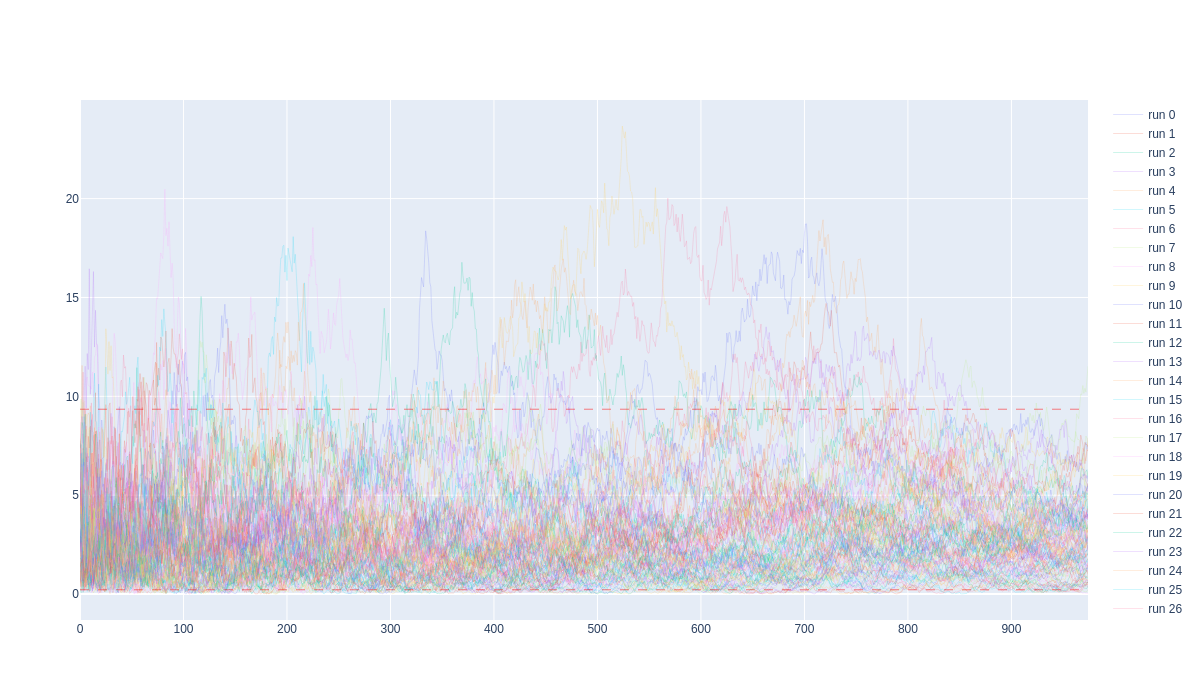

In [25]:
display(plot_runs(e.position_nees))

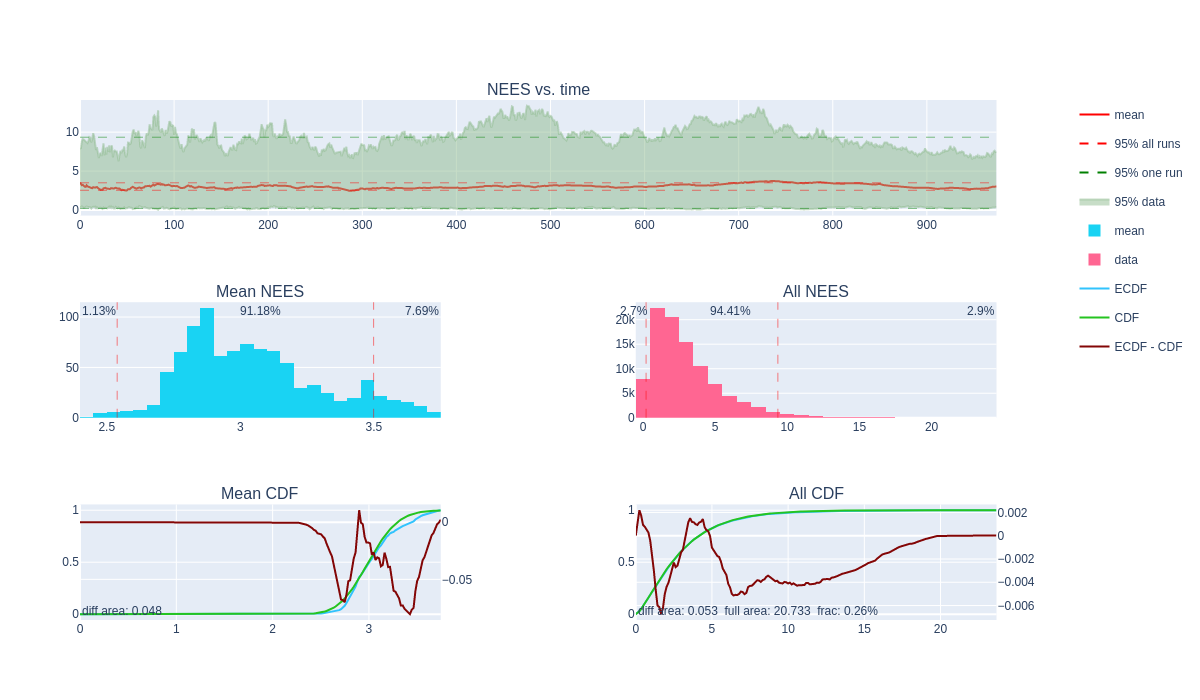

In [26]:
display(plot_nscore(e.position_nees))

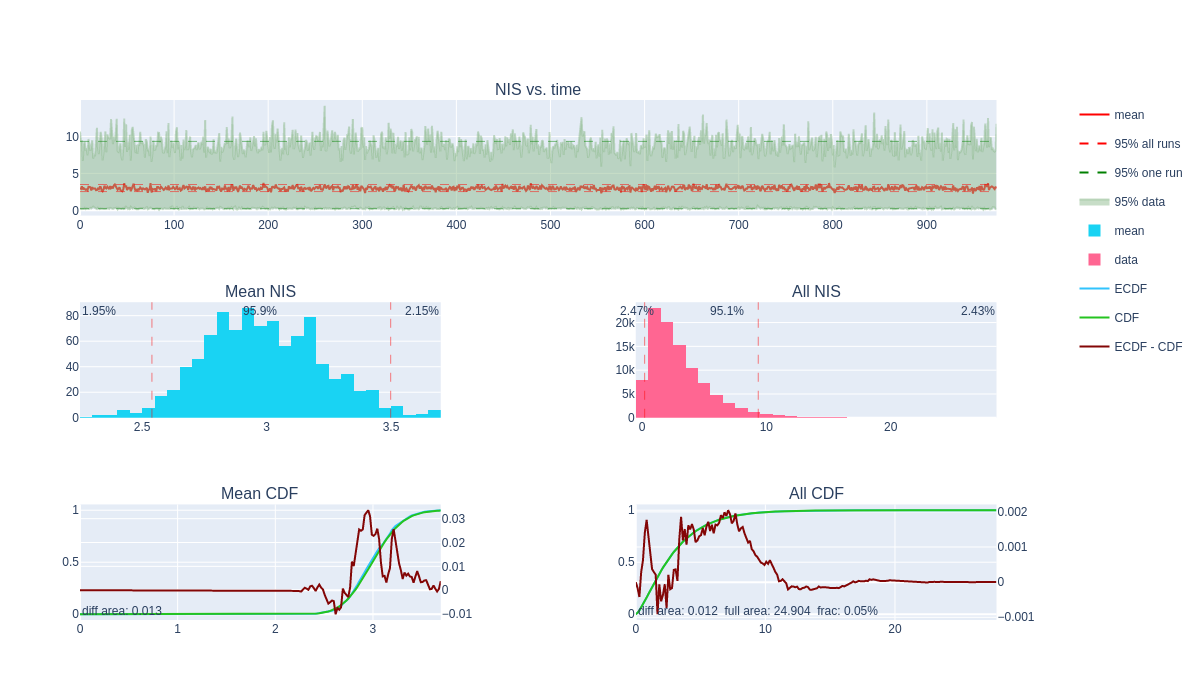

In [27]:
display(plot_nscore(e.position_nis))